## Quantifying Lexical Quality

To quantify lexical quality, I will rely on the following metrics, the rationale for which can be found in my thesis report:
<br>

1. Measure of Textual, Lexical Diversity (MTLD)
2. Yule's Characertistic Constant (K)
3. Zipf Distribution's Z Parameter (Z Score)
4. Average Age of Acquisition (Mean AoA)
5. Ratio of Words in the New Academic Word List (NAWL Ratio)

In choosing these metrics, I successfully capture lexical diversity, frequency distributions, word probability distributions, and word sophistication.

## Package Imports

In [4]:
# general imports
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from convokit import Corpus, download
from tqdm import tqdm
import nltk

# set up nltk tokenizers
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer
nltk.download('punkt_tab')

# set up nltk lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# imports specific to lexical measures
import re
from wordfreq import zipf_frequency
from lexical_diversity import lex_div as ld
from collections import Counter


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nv9344\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nv9344\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nv9344\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Lexical Helper Functions

In [5]:
def tokenize(text):
    '''Helper function to tokenize social media text. Note that the TweetTokenizer 
    preserves mentions, contractions, and other social media-specific structures'''
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)

    return tokens

In [6]:
def lemmatize(tokens):
    '''Helper function to lemmatize tokens.'''

    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return lemmatized_tokens

In [7]:
def clean_tokens_lexical(text):
    '''Helper function that tokenizes text, cleans tokens by removing punctuation, numbers, and emojis
    for purely lexical analysis, and returns the cleaned, lemmatized tokens.'''

    # tokenize text
    tokens = tokenize(text)

    # clean tokens
    cleaned = []
    for tok in tokens:
        # skip over punctuation
        if re.match(r'^\W+$', tok):
            continue
        # skip over emojis

        # only keep alphabetic tokens
        if tok.isalpha():
            cleaned.append(tok.lower())

    # lemmatize clean tokens
    lemmatized = lemmatize(cleaned)

    return lemmatized

## Lexical Analysis Functions

In [8]:
def mtld_score(clean_tokens):
    '''Function that returns the MTLD score for a given set of cleaned, lemmatized tokens.
    A higher MTLD score indicates higher lexical diversity.'''

    # compute mtld
    mtld_score = ld.mtld(clean_tokens)

    return mtld_score

In [9]:
def yules_K(clean_tokens):
    '''Function that returns Yule's characteristic constant K for a given set of 
    cleaned, lemmatized tokens. A lower Yule's K indicates higher lexical diversity.'''

    N = len (clean_tokens)
    if N == 0:
        return 0.0
    
    # count how many times each word occurs
    freq_counts = Counter(clean_tokens)

    # create V_i
    V = Counter(freq_counts.values()) # keys are frequencies, values are counts of types

    # compute sum of i^2 * V_i
    sum_isq_vi = sum((i**2) * Vi for i, Vi in V.items())

    # apply Yule's formula
    K = 10000 * ((sum_isq_vi - N)/(N**2))

    return K

In [10]:
def zipf_score(clean_tokens):
    '''Returns the average frequency score (higher -> more frequent) based on the Zipf scale
    for a given set of cleaned, lemmatized tokens. A higher Zipf score corresponds to higher
    lexical diversity.'''
    
    # compute Zipf parameter Z for each word
    zipf_values = [zipf_frequency(word, 'en') for word in clean_tokens]

     # if there are no words, return a default value
    if len(zipf_values) == 0:
        return np.nan

    # find the average zipf parameter
    zipf_score = np.mean(zipf_values)

    return zipf_score

In [11]:
# build aoa_dict: word -> average age of acquisition
aoa_df = pd.read_csv("Data/KupermanAoAData.csv")
aoa_dict = dict(zip(aoa_df["word"], aoa_df["rating_mean"]))

def aoa_score(clean_tokens, aoa_dict=aoa_dict):
    '''Returns the average age of acquisition score for a set of cleaned, lemmatized tokens.
    A higher mean AoA score indicates higher lexical difficulty.'''
    
    # extract aoa value only if the word is in the AoA dict
    aoa_values = [aoa_dict[word] for word in clean_tokens if word in aoa_dict]

    # if there are no words, return a default value
    if len(aoa_values) == 0:
        return np.nan
    
    # average the aoa values across all words
    aoa_score = np.mean(aoa_values)

    return aoa_score

In [12]:
# import NAWL list of academic words
nawl_list = pd.read_csv("Data/nawl_cleaned.csv")

def nawl_ratio(clean_tokens, nawl_list=nawl_list):
    '''Returns the ratio of words present in the NAWL given a set of cleaned, lemmatized tokens.
    A higher NAWL ratio indicates higher academic lexical sophistication.'''

    # compute the total number of words
    total_num_words = len(clean_tokens)

    # if there are no tokens, return null value
    if total_num_words == 0:
        return np.nan

    num_nawl_words = 0
    # compute the number of values in NAWL
    for word in clean_tokens:
        if word in nawl_list:
            num_nawl_words += 1

    # compute the nawl ratio
    nawl_ratio = num_nawl_words / total_num_words

    return nawl_ratio

## Corpus Selection

In [18]:
corpus = Corpus(filename="../subreddit-teenagers")

## Data Analysis

In [14]:
# collect utterances into a list
utterance_data = []
for utt in corpus.iter_utterances():
    # only consider utterances with timestamps and text
    if hasattr(utt, "timestamp") and utt.text:

        # convert timestamp from seconds since 1/1/1970 to datetime
        t = datetime.fromtimestamp(int(utt.timestamp))
        # tokenize, clean, lemmatize
        tokens = clean_tokens_lexical(utt.text)

        # compute scores
        mtld_val = mtld_score(tokens)
        yules_val = yules_K(tokens)
        zipf_val = zipf_score(tokens)
        aoa_val = aoa_score(tokens)
        nawl_val = nawl_ratio(tokens)

        # store results for each utterance
        utterance_data.append({
                        "time": t,
                        "mtld_score": mtld_val,
                        "yules_k": yules_val,
                        "zipf_score": zipf_val,
                        "aoa_score": aoa_val,
                        "nawl_ratio": nawl_val
                    })
    
# convert to a dataframe for easy data analysis
df = pd.DataFrame(utterance_data)
df.sort_values("time", inplace=True)
df.head()

,time,mtld_score,yules_k,zipf_score,aoa_score,nawl_ratio
6332,2009-06-22 00:29:39,0.0,0.0,4.180000,NaN,0.0
6333,2009-06-22 00:34:48,0.0,0.0,4.180000,NaN,0.0
9264,2009-06-24 23:48:52,0.0,0.0,5.383000,6.000000,0.0
9265,2009-06-24 23:55:42,0.0,0.0,5.335455,6.328889,0.0
6334,2009-06-26 14:20:22,0.0,0.0,4.180000,NaN,0.0


In [15]:
# aggregate metrics by month
df.set_index('time', inplace=True)
numeric_cols = ['mtld_score', 'yules_k', 'zipf_score', 'aoa_score', 'nawl_ratio']
monthly_metrics = df[numeric_cols].resample('ME').mean()

df.head()

,mtld_score,yules_k,zipf_score,aoa_score,nawl_ratio
time,,,,,
2009-06-22 00:29:39,0.0,0.0,4.180000,NaN,0.0
2009-06-22 00:34:48,0.0,0.0,4.180000,NaN,0.0
2009-06-24 23:48:52,0.0,0.0,5.383000,6.000000,0.0
2009-06-24 23:55:42,0.0,0.0,5.335455,6.328889,0.0
2009-06-26 14:20:22,0.0,0.0,4.180000,NaN,0.0


## Plot

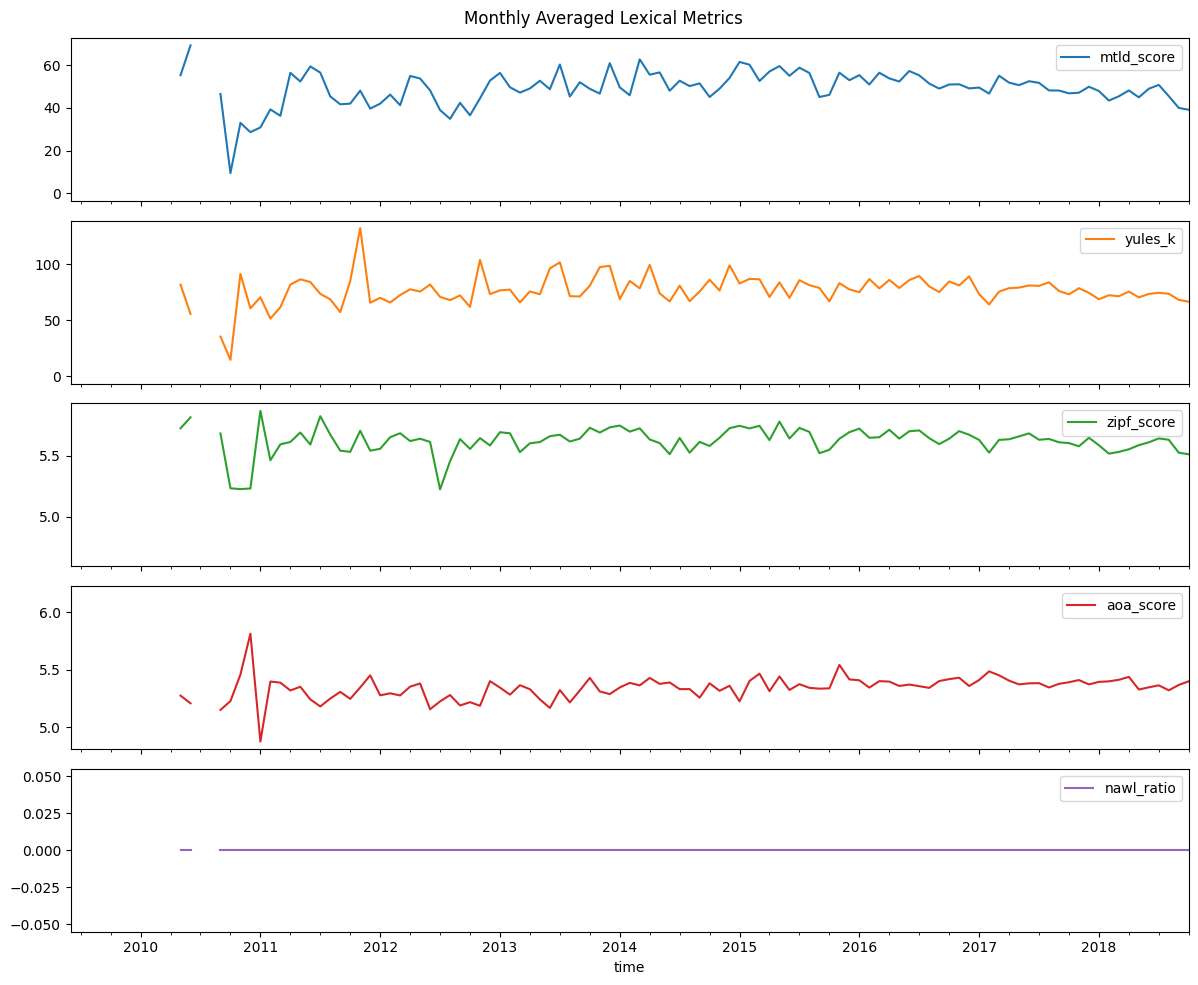

In [16]:
# plot monthly average metrics
monthly_metrics.plot(
    subplots=True,
    figsize=(12, 10),
    layout=(5, 1),
    title="Monthly Averaged Lexical Metrics",
    legend=True
)

plt.tight_layout()
plt.show()

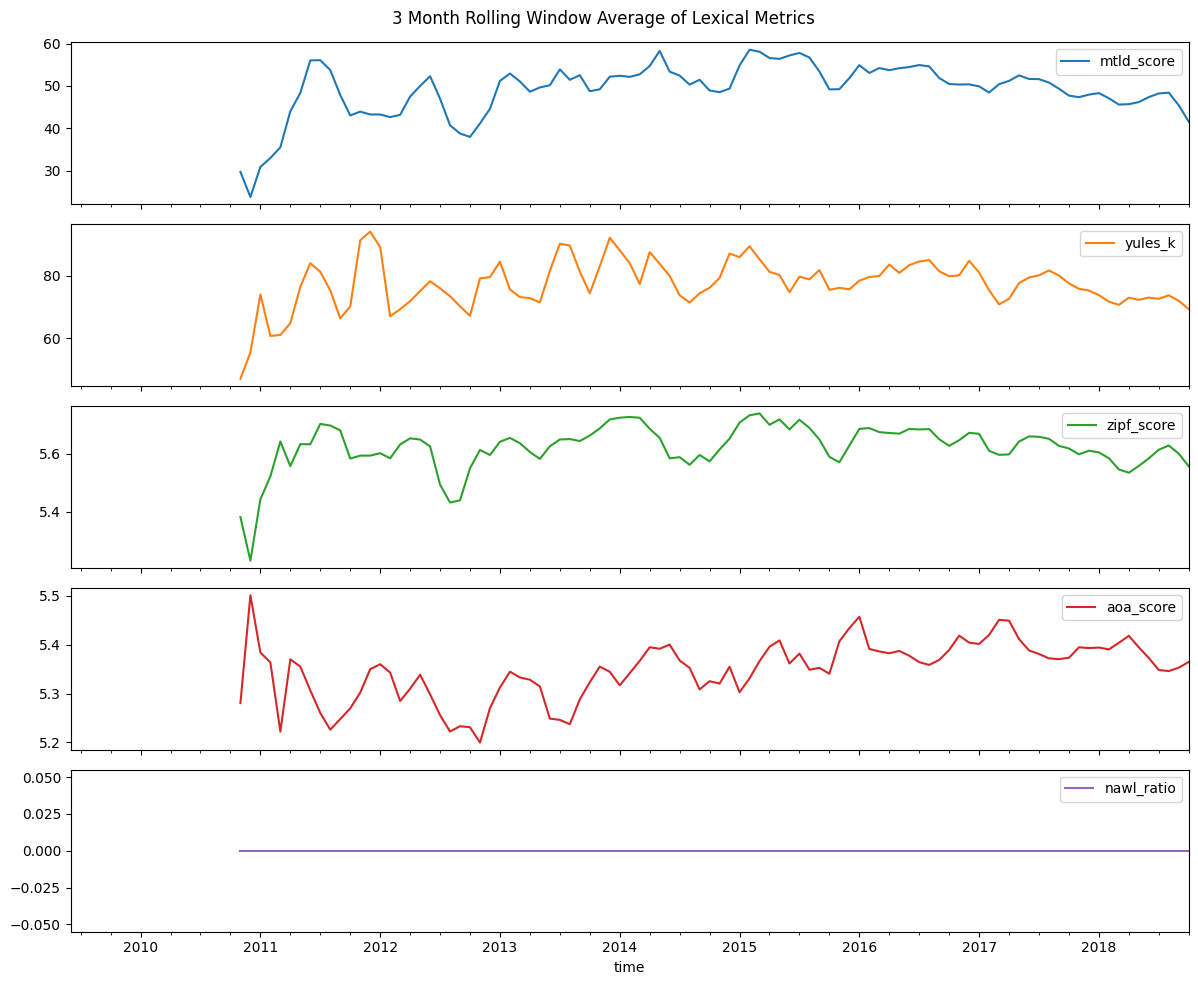

In [19]:
# smooth metrics for clear visualization by using quarterly rolling window
monthly_smooth = monthly_metrics[numeric_cols].rolling(3).mean()

# plot quarterly rolling window metrics
monthly_smooth.plot(
    subplots=True,
    figsize=(12, 10),
    layout=(5, 1),
    title="3 Month Rolling Window Average of Lexical Metrics",
    legend=True
)

plt.tight_layout()
plt.show()